## Metrics (Training Results)

- This notebook shows the training results of different models, including CNN and Particle Transformer.
- Most of the training results are repeated 10 times with different random seeds.
- The signal and background were set to be Higgs from VBF and GGF, respectively.

In [16]:
from itertools import product

import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns

sns.set_theme()

# Define the root of the project
ROOT = Path.cwd().parent

def get_metrics(channel: str, model: str, data_mode: str, date_time: str, data_suffix: str = '', num_rnd: int = None):
    """Print summary metrics for different models under given configuration."""

    # Define path to metrics output
    output_dir = ROOT / 'output'

    # Loop through models
    df = pd.DataFrame()

    # Collect metrics from each random seed run
    rnd_seed = 123

    for _ in range(num_rnd):
        metrics_file = Path(channel) / data_mode / f"{model}-{date_time}-{data_suffix}" / f'rnd_seed-{rnd_seed}' / 'metrics.csv'
        if not (output_dir / metrics_file).exists():
            print(f"Warning: Metrics file {metrics_file} does not exist. Stopping further checks for this model.")
            break

        df_tmp = pd.read_csv(output_dir / metrics_file)
        test_metrics = df_tmp.tail(1)
        df = pd.concat([df, pd.DataFrame({
            'model': model,
            'rnd_seed': rnd_seed,
            'test_accuracy': test_metrics['test_accuracy'].values,
            'test_auc': test_metrics['test_auc'].values,
            'epoch': test_metrics['epoch'].values
        })], ignore_index=True)

        rnd_seed += 100

    return df

## $H \rightarrow \gamma \gamma$

#### Keras-like settings

- 20251001_052410
- Keras parameter initialization
- Keras batch normalizaiton in CNN

#### PyTorch default settings (240K ParT + remove only decay product)

- 20250930_105915 : +0
- 20250923_232355 : +5
- 20250924_111848 : +10

#### PyTorch default settings (9.5K ParT + remove also neighbors nearby decay product)

- 20251005_154731 : +0
- 20251006_114628 : +5
- 20251007_015709 : +10

#### More lighter ParT (2.7K)
- 20251008_004504
- 20251008_150811
- 20251009_024328

In [17]:
df = pd.DataFrame()
info_list = [
    ('CNN_EventCNN', '20251005_154731', '+0'),
    ('CNN_EventCNN', '20251006_114628', '+5'),
    ('CNN_EventCNN', '20251007_015709', '+10'),

    ('ParT_Light', '20251005_154731', '+0'),
    ('ParT_Light', '20251006_114628', '+5'),
    ('ParT_Light', '20251007_015709', '+10'),
]

luminosity_list = [100, 300, 900, 1800, 3000]
for model, date_time, num_rot_aug in info_list:
    for channel, luminosity in product(['diphoton', 'ex-diphoton'], luminosity_list):
        tmp_df = get_metrics(channel=channel, model=model, data_mode='jet_flavor', date_time=date_time, data_suffix=f'L{luminosity}', num_rnd=10)
        tmp_df['channel'] = channel
        tmp_df['date_time'] = date_time
        tmp_df['luminosity'] = luminosity
        tmp_df['num_rot_aug'] = num_rot_aug
        df = pd.concat([df, tmp_df], ignore_index=True)

df.loc[df['model'] == 'CNN_EventCNN', 'model_paper'] = 'CNN'
df.loc[df['model'] == 'ParT_Light', 'model_paper'] = 'ParT'

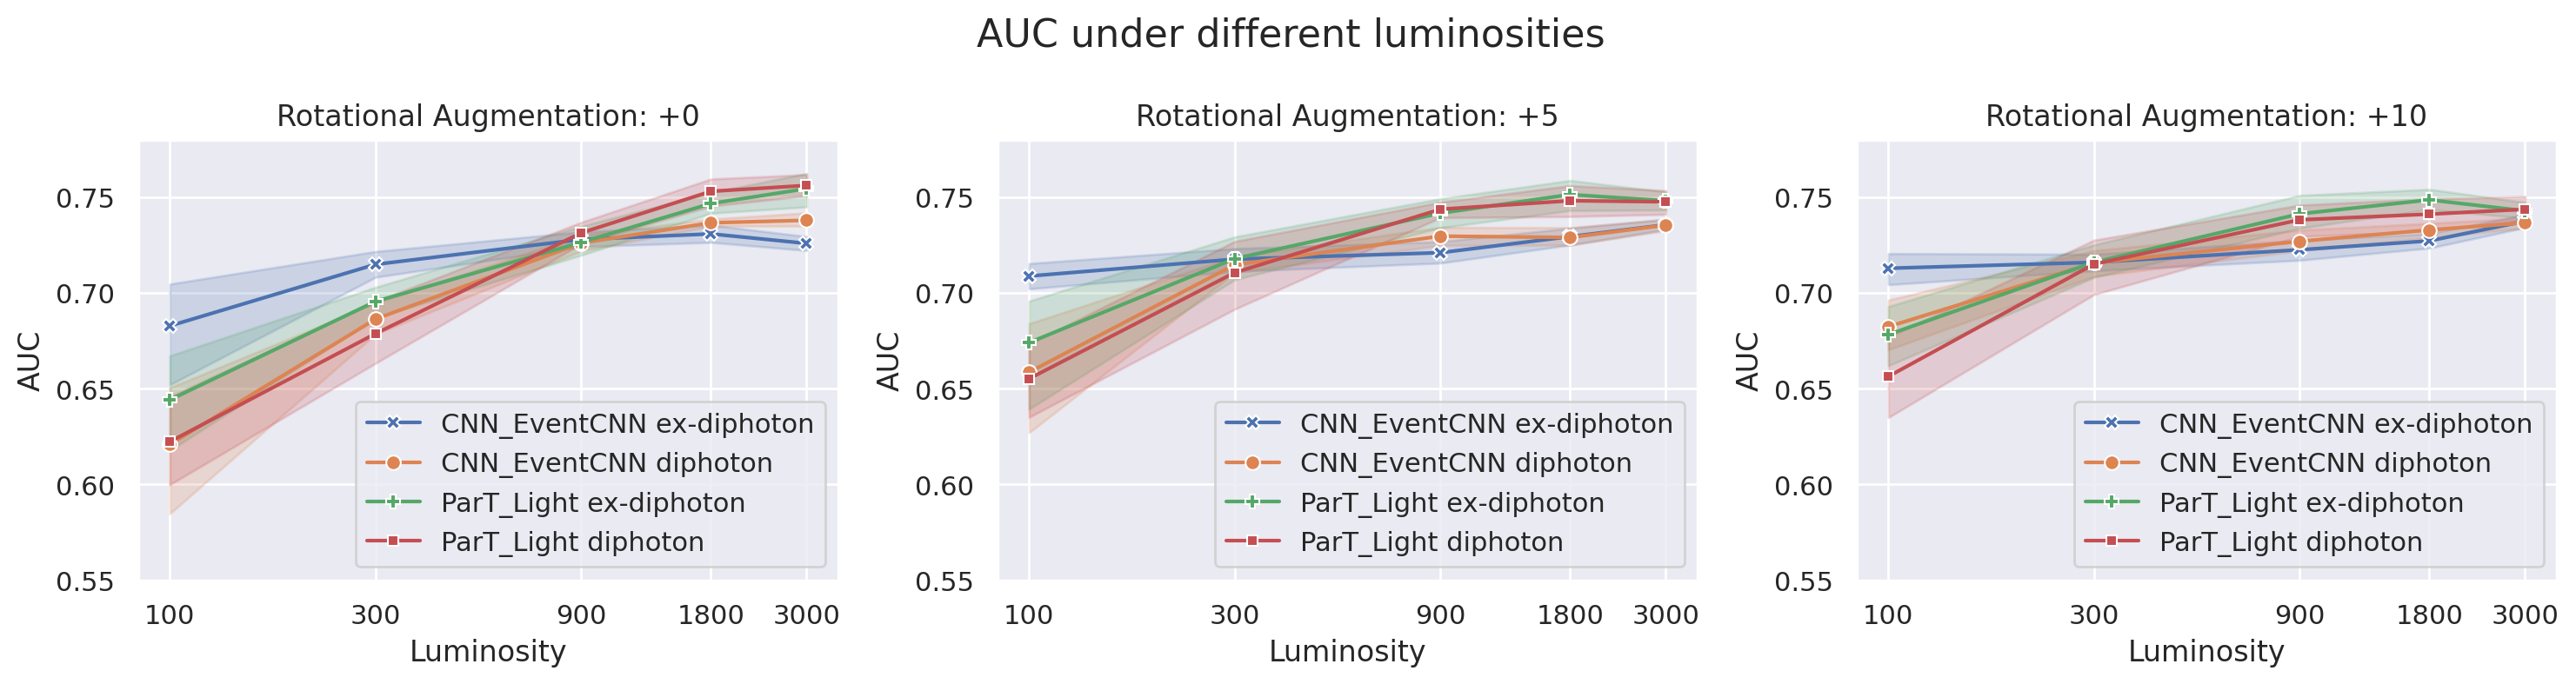

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=200)
fig.suptitle(f"AUC under different luminosities", fontsize=16)

# Add combined model-channel column for hue
df["hue"] = df["model"] + " " + df["channel"]
hue_order = ['CNN_EventCNN ex-diphoton', 'CNN_EventCNN diphoton', 'ParT_Light ex-diphoton', 'ParT_Light diphoton']

for i, num_rot_aug in enumerate(['+0', '+5', '+10']):
    tmp_df = df[df['num_rot_aug'] == num_rot_aug]
    sns.lineplot(data=tmp_df, x='luminosity', y='test_auc', hue='hue', hue_order=hue_order, style='hue', markers=True, dashes=False, ax=ax[i])
    ax[i].set_title(f"Rotational Augmentation: {num_rot_aug}")
    ax[i].set_xscale("log")
    ax[i].set_xticks(luminosity_list)
    ax[i].set_xticklabels(luminosity_list)
    ax[i].set_ylim(0.55, 0.78)
    ax[i].set(xlabel="Luminosity", ylabel="AUC")
    ax[i].legend()

plt.tight_layout()
plt.show()

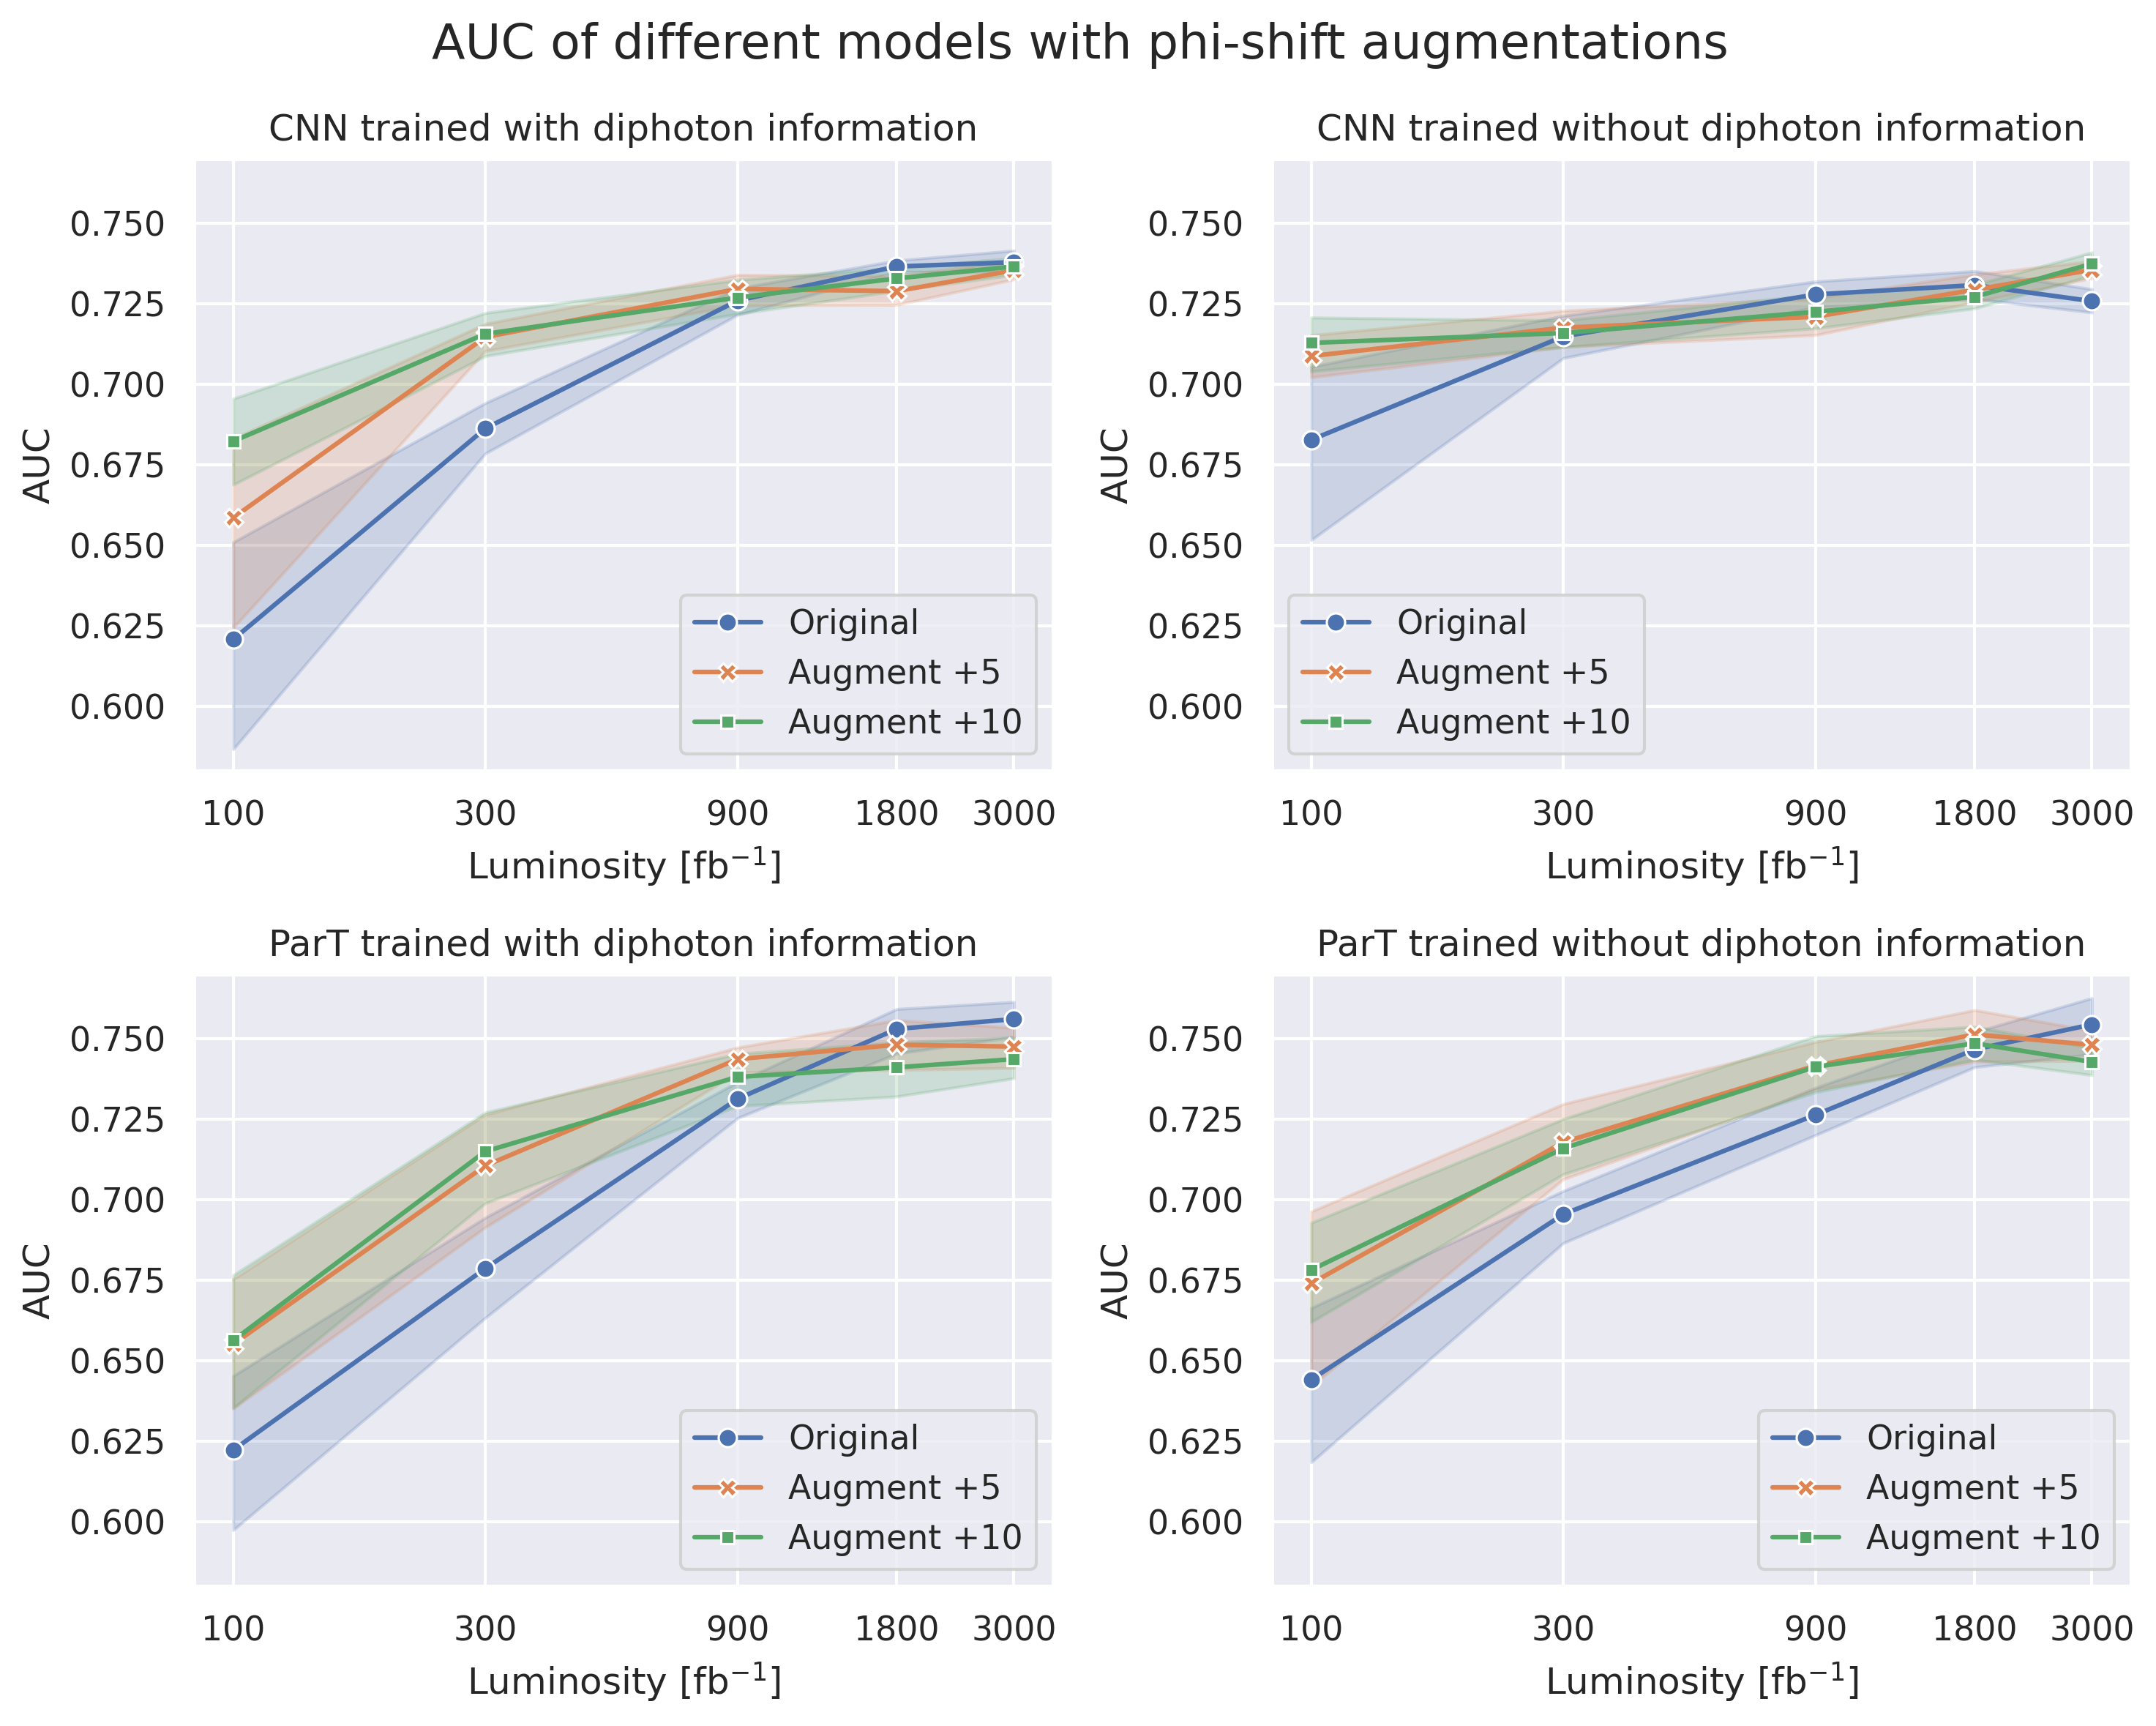

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
fig.suptitle(f"AUC of different models with phi-shift augmentations", fontsize=16)

# Add combined model-channel column for hue
# df["hue"] = df["model_paper"] + " " + df["num_rot_aug"]
df["hue"] = "Augment " + df["num_rot_aug"]
df.loc[df['hue'] == 'Augment +0', 'hue'] = 'Original'

for i, model_paper in enumerate(['CNN', 'ParT']):
    for j, channel in enumerate(['diphoton', 'ex-diphoton']):
        tmp_df = df[(df['model_paper'] == model_paper) & (df['channel'] == channel)]
        sns.lineplot(data=tmp_df, x='luminosity', y='test_auc', hue='hue', style='hue', markers=True, dashes=False, ax=ax[i, j])
        if channel == 'diphoton':
            ax[i, j].set_title(f"{model_paper} trained with diphoton information")
        else:
            ax[i, j].set_title(f"{model_paper} trained without diphoton information")
        ax[i, j].set_xscale("log")
        ax[i, j].set_xticks(luminosity_list)
        ax[i, j].set_xticklabels(luminosity_list)
        ax[i, j].set_ylim(0.58, 0.77)
        ax[i, j].set(xlabel=r"Luminosity [fb$^{-1}$]", ylabel="AUC")
        ax[i, j].legend()

plt.tight_layout()
plt.show()
fig.savefig(ROOT / 'figures' / 'AUC_diphoton.pdf')

## $H \rightarrow \gamma \gamma$ apply to $H \rightarrow ZZ \rightarrow 4l$

- The inference used data and trained models that **WITHOUT** decay products.

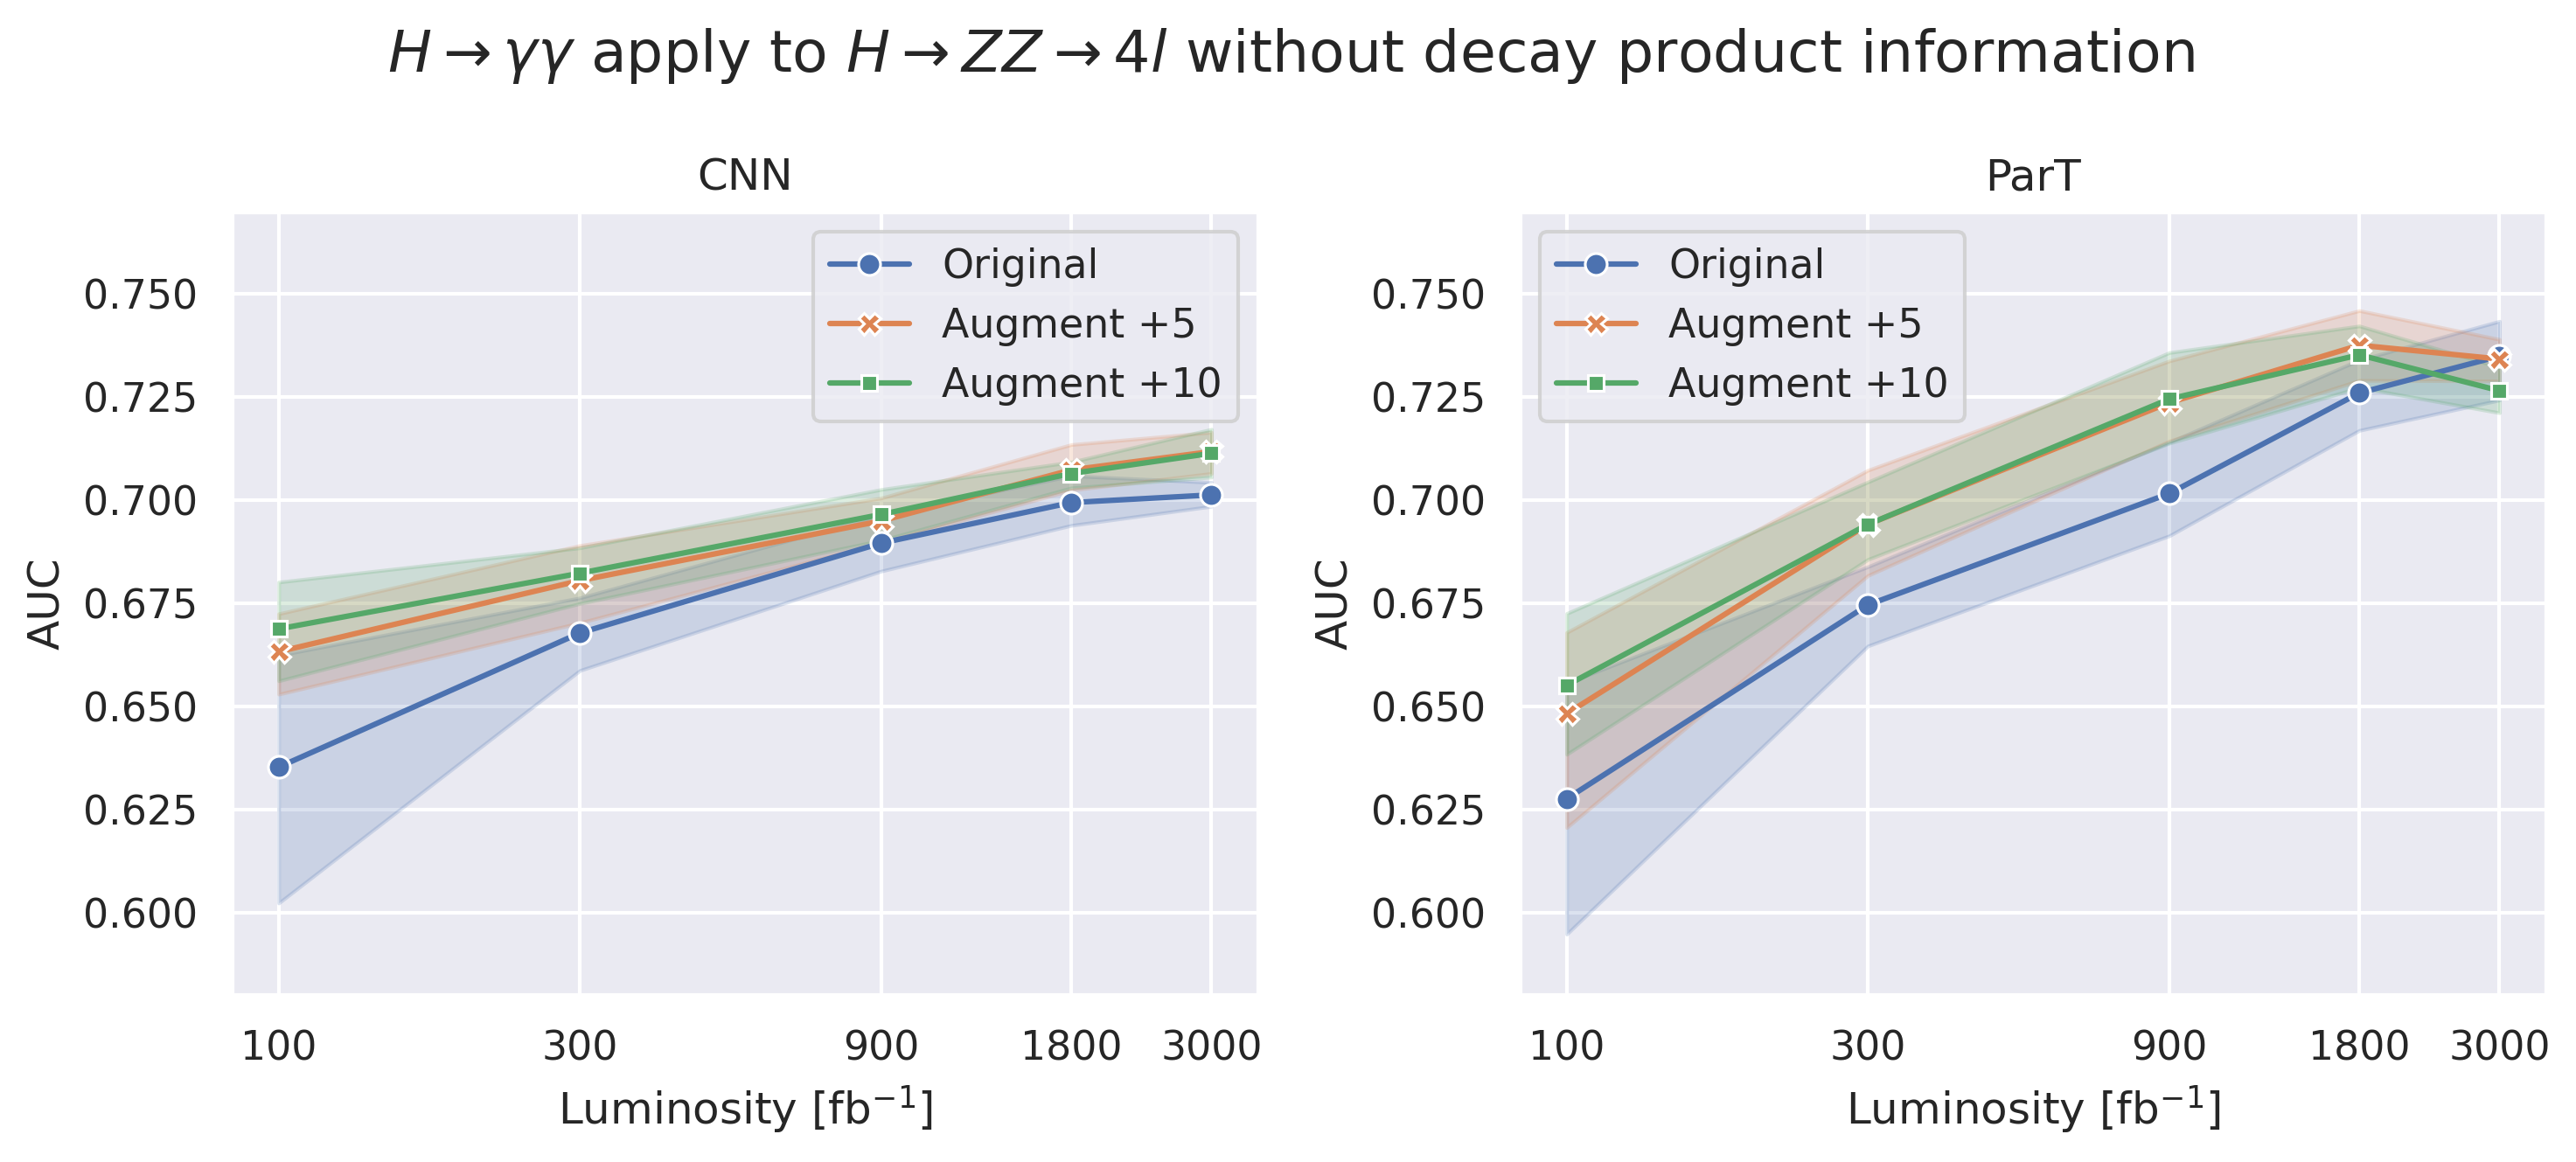

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5), dpi=300)
fig.suptitle(r"$H\rightarrow\gamma\gamma$ apply to $H\rightarrow ZZ\rightarrow 4l$ without decay product information", fontsize=16)

inference_info_list = [
    # Removing also neighbors near decay product
    ('image', 'CNN_EventCNN', '20251005_154731', 'Original'),
    ('image', 'CNN_EventCNN', '20251006_114628', 'Augment +5'),
    ('image', 'CNN_EventCNN', '20251007_015709', 'Augment +10'),
    ('sequence', 'ParT_Light', '20251005_154731', 'Original'),
    ('sequence', 'ParT_Light', '20251006_114628', 'Augment +5'),
    ('sequence', 'ParT_Light', '20251007_015709', 'Augment +10'),
]

inf_df = pd.DataFrame()
for (data_format, model, date_time, aug_info) in inference_info_list:
    tmp_df = pd.read_csv(ROOT / 'output' / 'inference' / f"{model}_{date_time}.csv")
    tmp_df['hue'] = aug_info
    inf_df = pd.concat([inf_df, tmp_df], ignore_index=True)

inf_df.loc[inf_df['model'] == 'CNN_EventCNN', 'model_paper'] = 'CNN'
inf_df.loc[inf_df['model'] == 'ParT_Light', 'model_paper'] = 'ParT'

for i, model_paper in enumerate(['CNN', 'ParT']):
    tmp_df = inf_df[inf_df['model_paper'] == model_paper]
    sns.lineplot(data=tmp_df, x='luminosity', y='test_auc', hue='hue', style='hue', markers=True, dashes=False, ax=ax[i])
    ax[i].set_xscale("log")
    ax[i].set_xticks(luminosity_list)
    ax[i].set_xticklabels(luminosity_list)
    ax[i].set(xlabel=r"Luminosity [fb$^{-1}$]", ylabel="AUC")
    ax[i].set_title(f"{model_paper}")
    ax[i].set_ylim(0.58, 0.77)
    ax[i].legend()

plt.tight_layout()
plt.show()
fig.savefig(ROOT / 'figures' / 'AUC_zz4l.pdf')